In [2]:
{-# LANGUAGE OverloadedStrings #-}
{-# LANGUAGE InstanceSigs #-}
{-# LANGUAGE FlexibleInstances #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE OverloadedStrings #-}
Why not:
Line 2: Unused LANGUAGE pragma
Found:
{-# LANGUAGE InstanceSigs #-}
Why not:

In [3]:
import Graphics.Svg
import qualified IHaskell.Display as D
import qualified Data.Text as T
import qualified Data.List as List
-- import Debug.Trace (trace)

In [4]:
renderSvg :: Element -> Element
renderSvg content =
     doctype
  <> with (svg11_ content) [Version_ <<- "1.1", Width_ <<- "300", Height_ <<- "200"]

In [5]:
contents :: Element
contents =
     rect_ [ Width_ <<- "100%", Height_ <<- "100%", Fill_ <<- "red" ]
  <> circle_ [ Cx_ <<- "150", Cy_ <<- "100", R_ <<- "80", Fill_ <<- "green" ]
  <> text_ [ X_ <<- "150", Y_ <<- "125", Font_size_ <<- "60"
           , Text_anchor_ <<- "middle", Fill_ <<- "white" ] "SVG"

In [6]:
renderSvg contents

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
    "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd"><svg xmlns="http://www.w3.org/2000/svg" height="200" width="300" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.11.1"><rect height="100%" width="100%" fill="red"/><circle fill="green" cy="100" r="80" cx="150"/><text font-size="60" fill="white" x="150" text-anchor="middle" y="125">SVG</text></svg>

Instancing the `IHaskellDisplay` typeclass allows elements to be displayed rather than returned as an SVG string

In [7]:
instance D.IHaskellDisplay Element where
  display :: Element -> IO D.Display
  display = D.display . D.svg . show . renderSvg

In [8]:
renderSvg contents

Custom operator for relaxing the type of `AttrTag` args to include all Showable types (instead of just Text)

In [9]:
(<<-*) :: Show a => AttrTag -> a -> Attribute
(<<-*) tag a = bindAttr tag (T.pack (show a))

Let SVG height be determined by height of constituent geoms to avoid clipping

Double is used because `translate` takes a `RealFloat` instance downstream

In [10]:
type Height = Double

In [11]:
makeSvg :: (Height, Element) -> Element
makeSvg (height, geom) =
     doctype
  <> with (svg11_ geom) [Version_ <<- "1.1", Height_ <<-* height]

Some primitives for drawing and chaining items

In [12]:
box :: Double -> Double -> Double -> Double -> Element
box x y w h = 
  rect_ [ X_ <<-* x, Y_ <<-* y, Width_ <<-* w, Height_ <<-* h
        , Fill_ <<- "none", Stroke_ <<- "black" ]

In [13]:
line :: (Double , Double) -> (Double, Double) -> Element
line (x1, y1) (x2, y2) =
  line_ [ X1_ <<-* x1, X2_ <<-* x2, Y1_ <<-* y1, Y2_ <<-* y2
        , Stroke_ <<- "grey" ]

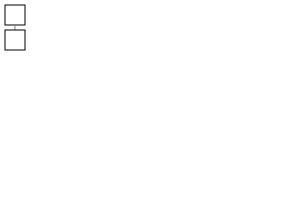

In [14]:
box 5 5 20 20
  <> line (15, 25) (15, 30)
  <> box 5 30 20 20

In [15]:
item :: Double -> Double -> Element -> Element
item x y desc =
  let w = 20
  in 
    g_ [] (   box x y w w
           <> text_ [ X_ <<-* (x + w + 5), Y_ <<-* (y + w - 5) ] desc )

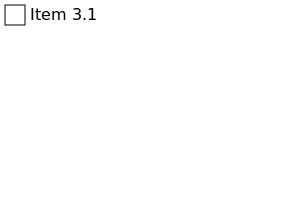

In [16]:
item 5 5 "Item 3.1"

In [17]:
:t translate

translate :: forall a. RealFloat a => a -> a -> Text

Translates an element by (x, y)

In [18]:
move :: (Double, Double) -> Element -> Element
move (x, y) geoms =
  with geoms [Transform_ <<- translate x y]

A series of downward translations

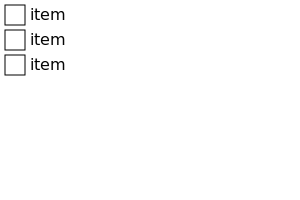

In [19]:
move (5,5) (item 0 0 "item") 
  <> move (5,30) (item 0 0 "item") 
  <> move (5,55) (item 0 0 "item")

Nesting moves and extracting the common factor

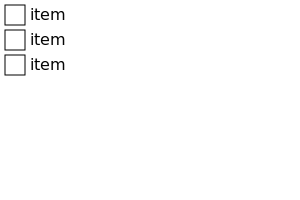

In [20]:
move (5,5) 
     (item 0 0 "item" 
   <> move (0,25) 
           (item 0 0 "item" 
         <> move (0,25) 
                 (item 0 0 "item")))

Chaining moves

In [21]:
chain :: [Element] -> Element
chain [] = mempty
chain [g] = g
chain (g:gs) =
  g_ [] (g
      <> line (10, 20) (10, 25)
      <> move (0, 25) (chain gs))

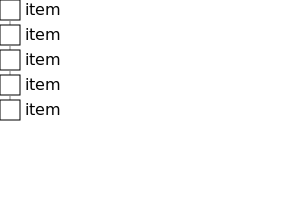

In [22]:
chain $ replicate 5 (item 0 0 "item")

In [23]:
type Label = Element

In [24]:
data Item = 
    Leaf Label
  | All Label [Item]
  | Any Label [Item]
  deriving Show

Let each render function return the geometry and each item's height

In [25]:
renderChain :: [(Height, Element)] -> Element
renderChain [] = mempty
renderChain [(_,g)] = g
renderChain ((h,g):hgs) = 
  g_ [] (g
      <> line (10, 20) (10, h)
      <> move (0, h) (renderChain hgs))

Render functions are grouped in the same cell so nothing goes wrong with order of evaluation

In [26]:
renderLeaf :: Label -> (Height, Element)
renderLeaf label = 
  let height = 25
      geom = item 0 0 label
  in (height, geom)
  
renderAll :: Label -> [Item] -> (Height, Element)
renderAll label childnodes = 
  let 
      hg = map renderItem childnodes
      (hs, gs) = unzip hg
      height = sum hs + 30
      geom :: Element
      geom = g_ [] (item 0 0 label
                 <> line (15, 20) (15, 25) 
                 <> line (15, 25) (40, 25)
                 <> line (40, 25) (40, 30)
                 <> move (30, 30) (renderChain hg))
  in (height, geom)

renderAny :: Label -> [Item] -> (Height, Element)
renderAny label childnodes = 
  let hg = map renderItem childnodes
      (hs, gs) = unzip hg
      height = sum hs + 25
      geom :: Element
      geom = g_ [] (item 0 0 label
                 <> line (15, 20) (15, sum (init hs) + 25 + 10) 
                 <> move (30, 25) (go 0 hg))
                 where go y [] = mempty
                       go y ((h,g):hgs) = 
                         g_ [] (g
                             <> line (-15, 10) (0, 10)
                             <> move (0, h) (go (y+h) hgs))
  in (height, geom)

renderItem :: Item -> (Height, Element)
renderItem (Leaf label) = renderLeaf label
renderItem (All label args) = renderAll label args
renderItem (Any label args) = renderAny label args

Another `IHaskellDisplay` instance for displaying the augmented element type

In [27]:
instance D.IHaskellDisplay (Height, Element) where
  display :: (Height, Element) -> IO D.Display
  display = D.display . D.svg . show . makeSvg

Leaf test

In [28]:
renderItem (Leaf "a leaf")

All tests

In [29]:
renderItem (All "1"
             [ Leaf "1a", Leaf "1b", Leaf "1c" ])

In [30]:
renderItem (All "S"
             [ All "1" 
                [ Leaf "1a"
                , Leaf "1b" ]
             , All "2"
                [ Leaf "2a"
                , Leaf "2b"
                , Leaf "2c" ]
             , Leaf "3" ])

Any tests

In [31]:
renderItem (All "You need all of" 
             [ Leaf "Item 1;"
             , Leaf "Item 2;"
             , Any "Item 3 which may be satisfied by any of:" 
                [ Leaf "3.a;"
                , Leaf "3.b; or"
                , Leaf "3.c;" ]
             , Leaf "Item 4; and"
             , All "Item 5 which requires all of:"
                [ Leaf "5.a;"
                , Leaf "5.b; and"
                , Leaf "5.c." ] ])